<a href="https://colab.research.google.com/github/Arman2101392/Cse_425_project/blob/main/Cse425_project_23101392.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

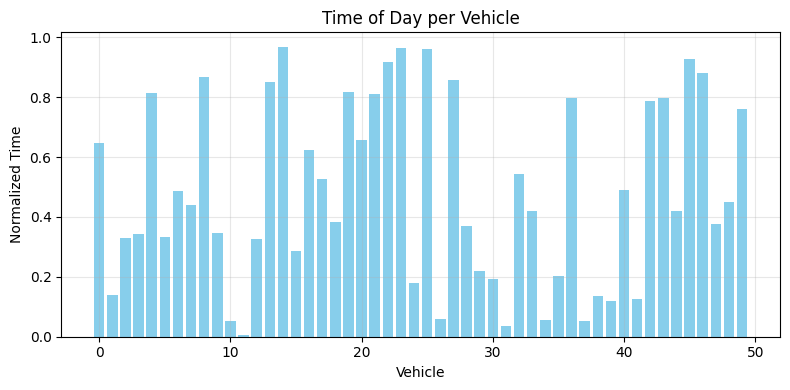

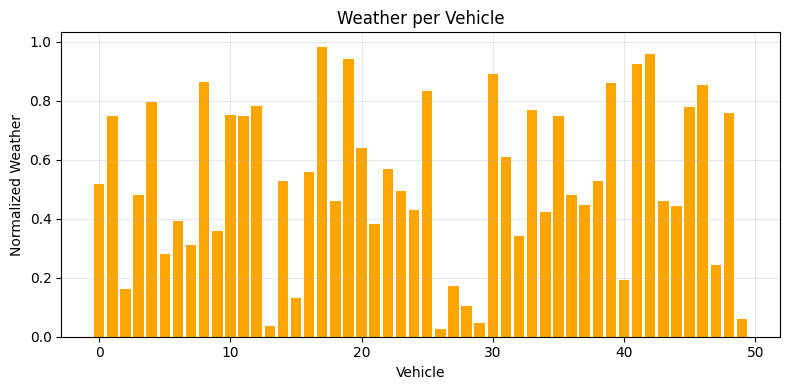

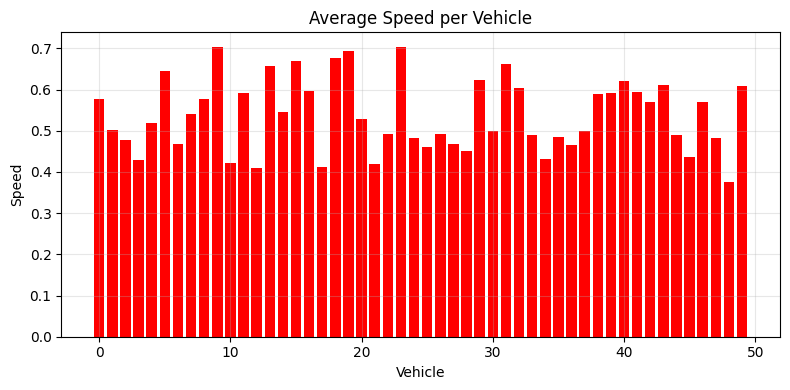

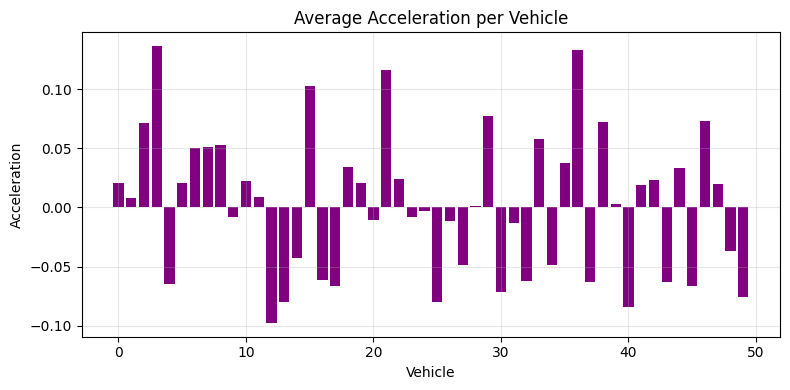

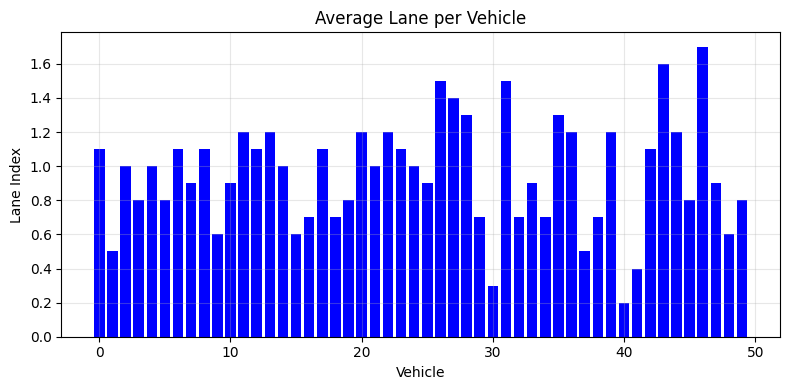

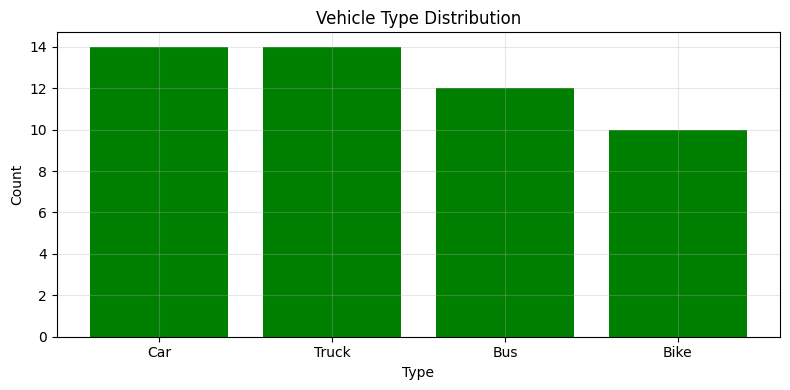

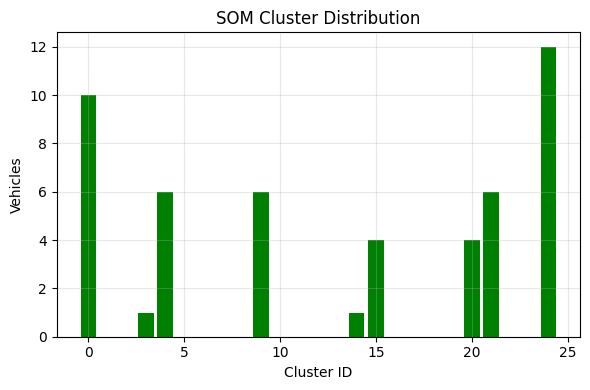

In [6]:
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np, matplotlib.pyplot as plt, plotly.graph_objects as go
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
!pip install -U kaleido
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_VEHICLES, SEQ_LEN, IMG_SIZE = 50, 10, 32
FEATURE_DIM_CNN, FEATURE_DIM_LSTM, SOM_GRID, SOM_EPOCHS = 16, 32, 5, 20
torch.manual_seed(42); np.random.seed(42)

# -----------------------------
# SIMULATED DATA
# -----------------------------
traffic_data = torch.rand(NUM_VEHICLES, SEQ_LEN, 1, IMG_SIZE, IMG_SIZE)
lane_data = torch.randint(0,3,(NUM_VEHICLES,SEQ_LEN,1)).float()
vehicle_types = F.one_hot(torch.randint(0,4,(NUM_VEHICLES,)), num_classes=4).float()
context_features = torch.rand(NUM_VEHICLES,2)
positions = torch.rand(NUM_VEHICLES,SEQ_LEN,2)

# SPEED & ACCELERATION
def compute_speed_acceleration(pos):
    s = torch.sqrt(((pos[:,1:]-pos[:,:-1])**2).sum(dim=2))
    s = torch.cat([s[:,0:1],s],dim=1)
    a = s[:,1:]-s[:,:-1]
    a = torch.cat([a[:,0:1],a,a[:,-1:]],dim=1)
    return s.unsqueeze(2), a.unsqueeze(2)
speeds, accels = compute_speed_acceleration(positions)

# -----------------------------
# MODELS
# -----------------------------
class CNNFeatureExtractor(nn.Module):
    def __init__(self,input_channels=1,feature_dim=FEATURE_DIM_CNN):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels,input_channels,3,padding=1,groups=input_channels),
            nn.Conv2d(input_channels,feature_dim,1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    def forward(self,x): return self.conv(x).view(x.size(0),-1)

class LSTMFeat(nn.Module):
    def __init__(self,input_dim,hidden_dim=FEATURE_DIM_LSTM):
        super().__init__(); self.lstm = nn.LSTM(input_dim,hidden_dim,batch_first=True)
    def forward(self,x): return self.lstm(x)[1][0][-1]

class SelfAttention(nn.Module):
    def __init__(self,dim): super().__init__(); self.q = nn.Linear(dim,dim); self.k = nn.Linear(dim,dim); self.v = nn.Linear(dim,dim)
    def forward(self,x):
        Q,K,V = self.q(x),self.k(x),self.v(x)
        return torch.matmul(F.softmax(Q@K.transpose(-2,-1)/np.sqrt(x.size(-1)),dim=-1),V).mean(dim=1)

class MiniBatchSOM(nn.Module):
    def __init__(self,input_dim,m=SOM_GRID,n=SOM_GRID,lr0=0.5,sigma0=None,device='cpu'):
        super().__init__()
        self.m,self.n,self.dim = m,n,input_dim
        self.lr0,self.sigma0,self.device = lr0,sigma0 if sigma0 else max(1,0.8*max(m,n)),device
        init = 0.05*torch.randn(m*n,input_dim)
        self.weights = nn.Parameter(init.to(device),requires_grad=False)
        coords = [(i,j) for i in range(m) for j in range(n)]
        self.register_buffer("coords",torch.tensor(coords,dtype=torch.float32,device=device))
    @torch.no_grad()
    def fit(self,X,epochs=SOM_EPOCHS,batch_size=16,hard_radius_factor=2.5):
        X=X.to(self.device); N=X.size(0); t,t_max=0,max(1,epochs*int(np.ceil(N/batch_size)))
        for _ in range(epochs):
            perm=torch.randperm(N,device=self.device)
            for i in range(0,N,batch_size):
                xb=X[perm[i:i+batch_size]]
                lr_t=self.lr0*np.exp(-t/t_max); sigma_t=self.sigma0*np.exp(-t/t_max); sigma2=max(5e-4,sigma_t**2)
                d=torch.cdist(xb,self.weights,p=2); bmu_idx=d.argmin(dim=1); bmu_xy=self.coords[bmu_idx]
                diff=bmu_xy.unsqueeze(1)-self.coords.unsqueeze(0); dist2=(diff**2).sum(dim=2)
                H=torch.exp(-dist2/(2*sigma2))
                if hard_radius_factor: rad2=(hard_radius_factor*sigma_t)**2; H*=(dist2<=rad2).float()
                H_sum=H.sum(dim=0); HX=H.t()@xb
                self.weights.add_(lr_t*(HX-H_sum[:,None]*self.weights)); t+=1
    @torch.no_grad()
    def map(self,X): return torch.cdist(X.to(self.device),self.weights,p=2).argmin(dim=1).cpu().numpy()

# -----------------------------
# 8. EXTRACT FEATURES
# -----------------------------
cnn = CNNFeatureExtractor(); test_frame=traffic_data[0,0].unsqueeze(0); cnn_out=cnn(test_frame)
LSTM_INPUT_DIM = cnn_out.shape[1]+3
lstm = LSTMFeat(LSTM_INPUT_DIM); attention=SelfAttention(FEATURE_DIM_LSTM)

vehicle_features=[]
for i in range(NUM_VEHICLES):
    seq_feats=[]
    for t in range(SEQ_LEN):
        frame=traffic_data[i,t]; cnn_feat=cnn(frame.unsqueeze(0))
        extra=torch.cat([speeds[i,t],accels[i,t],lane_data[i,t]],dim=0)
        seq_feats.append(torch.cat([cnn_feat.squeeze(0),extra]))
    seq_feats=torch.stack(seq_feats).unsqueeze(0)
    lstm_feat=lstm(seq_feats); att_feat=attention(lstm_feat.unsqueeze(1))
    vehicle_features.append(torch.cat([att_feat.view(-1), vehicle_types[i], context_features[i]]))
features=torch.stack(vehicle_features)

# -----------------------------
# 9. TRAIN SOM
# -----------------------------
som=MiniBatchSOM(features.shape[1]); som.fit(features); clusters=som.map(features)

# -----------------------------
# 10. PLOTLY SOM DASHBOARD
# -----------------------------
fig = go.Figure()
for i in range(NUM_VEHICLES):
    feat=features[i].detach().numpy(); cnn_feat=feat[:FEATURE_DIM_CNN]; speed_accel=feat[FEATURE_DIM_CNN:FEATURE_DIM_CNN+2]
    lane=feat[FEATURE_DIM_CNN+2:FEATURE_DIM_CNN+3]; vtype=feat[FEATURE_DIM_CNN+3:FEATURE_DIM_CNN+7]; context=feat[-2:]
    cluster_id=clusters[i]; row,col=divmod(cluster_id,SOM_GRID)
    hover_text=f"Vehicle {i+1}<br>SOM Cluster: {cluster_id}<br>CNN Avg: {cnn_feat.mean():.2f}<br>"\
               f"Speed: {speed_accel[0]:.2f}, Accel: {speed_accel[1]:.2f}<br>Lane: {lane[0]:.0f}<br>"\
               f"Type: Car:{vtype[0]}, Truck:{vtype[1]}, Bus:{vtype[2]}, Bike:{vtype[3]}<br>"\
               f"Time:{context[0]:.2f}, Weather:{context[1]:.2f}"
    fig.add_trace(go.Scatter(x=[row+np.random.rand()*0.3-0.15], y=[col+np.random.rand()*0.3-0.15],
                             mode='markers', marker=dict(size=12,color=cluster_id,colorscale='Viridis',showscale=False),
                             hoverinfo='text', hovertext=hover_text))
fig.update_layout(title="Traffic Flow Clusters on SOM", xaxis_title="SOM Row", yaxis_title="SOM Column",
                  xaxis=dict(tickmode='linear',tick0=0,dtick=1), yaxis=dict(tickmode='linear',tick0=0,dtick=1),
                  height=700,width=700)


# -----------------------------
# 11. MATPLOTLIB PLOTS
# -----------------------------
# Time of Day
plt.figure(figsize=(8,4)); plt.bar(range(NUM_VEHICLES), context_features[:,0].numpy(), color='skyblue')
plt.title("Time of Day per Vehicle"); plt.xlabel("Vehicle"); plt.ylabel("Normalized Time"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Weather
plt.figure(figsize=(8,4)); plt.bar(range(NUM_VEHICLES), context_features[:,1].numpy(), color='orange')
plt.title("Weather per Vehicle"); plt.xlabel("Vehicle"); plt.ylabel("Normalized Weather"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Average Speed
plt.figure(figsize=(8,4)); plt.bar(range(NUM_VEHICLES), speeds.mean(dim=1).squeeze().numpy(), color='red')
plt.title("Average Speed per Vehicle"); plt.xlabel("Vehicle"); plt.ylabel("Speed"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Average Acceleration
plt.figure(figsize=(8,4)); plt.bar(range(NUM_VEHICLES), accels.mean(dim=1).squeeze().numpy(), color='purple')
plt.title("Average Acceleration per Vehicle"); plt.xlabel("Vehicle"); plt.ylabel("Acceleration"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Lane
plt.figure(figsize=(8,4)); plt.bar(range(NUM_VEHICLES), lane_data.mean(dim=1).squeeze().numpy(), color='blue')
plt.title("Average Lane per Vehicle"); plt.xlabel("Vehicle"); plt.ylabel("Lane Index"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Vehicle Type Distribution
plt.figure(figsize=(8,4)); plt.bar(["Car","Truck","Bus","Bike"], vehicle_types.sum(dim=0).numpy(), color='green')
plt.title("Vehicle Type Distribution"); plt.xlabel("Type"); plt.ylabel("Count"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Cluster Distribution
plt.figure(figsize=(6,4)); u,c=np.unique(clusters,return_counts=True)
plt.bar(u,c,color='green'); plt.title("SOM Cluster Distribution"); plt.xlabel("Cluster ID"); plt.ylabel("Vehicles"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
fig.show()

In [4]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 4.5 MB/s eta 0:00:00
